# Capstone project 3: Sentiment Analysis

#### BACKGROUND
A large multinational corporation is seeking to automatically identify the sentiment that their customer base talks
about on social media. They would like to expand this capability into multiple languages. Many 3rd party tools exist
for sentiment analysis, however, they need help with under-resourced languages.

#### GOAL
Train a sentiment classifier (Positive, Negative, Neutral) on a corpus of the provided documents. Your goal is to
maximize accuracy. There is special interest in being able to accurately detect negative sentiment. The training data
includes documents from a wide variety of sources, not merely social media, and some of it may be inconsistently
labeled. Please describe the business outcomes in your work sample including how data limitations impact your
results and how these limitations could be addressed in a larger project.

#### DATA
* Link to data: http://archive.ics.uci.edu/ml/datasets/Roman+Urdu+Data+Set
* Stop words resource: https://github.com/haseebelahi/roman-urdu-stopwords

## Part 1: Data Wrangling and EDA

### 0.0 Load libraries

In [78]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline 

import re
from nltk.tokenize.toktok import ToktokTokenizer
from sklearn.feature_extraction.text import CountVectorizer

### 1.0 Load data

In [79]:
data = pd.read_csv("./data/Roman Urdu DataSet.csv", header=None)
data.columns=['Text', 'Sentiment']
data.head(10)

,Text,Sentiment
0,Sai kha ya her kisi kay bus ki bat nhi hai lak...,Positive
1,sahi bt h,Positive
2,"Kya bt hai,",Positive
3,Wah je wah,Positive
4,Are wha kaya bat hai,Positive
5,Wah kya baat likhi,Positive
6,Wha Itni sari khubiya,Positive
7,Itni khubiya,Positive
8,Ya allah rehm farma hm sab pe or zalimo ko hid...,Positive
9,Please Everyone AllAh S.w.T ka naam hAmesha Ba...,Positive


The data is well-structured. "Text" column has the text data. And "Sentiment" has Positive, Negative, or Neutral for each case.

### 2.0 Data wrangling and cleaning

#### 2.1 Data cleaning of missing values and typoes

In [80]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20229 entries, 0 to 20228
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Text       20228 non-null  object
 1   Sentiment  20229 non-null  object
dtypes: object(2)
memory usage: 316.2+ KB


In [81]:
data.Text.isnull().sum()

1

In [82]:
data.Sentiment.value_counts()

Neutral     8929
Positive    6013
Negative    5286
Neative        1
Name: Sentiment, dtype: int64

_**Quick note**_:

    1. "Text" looks having 1 missing value. The suggestion is to drop this case.
    2. "Sentiment" has no missing value, but has typo for one case. 

In [83]:
# Drop the case with missing value 
data.dropna(inplace=True)
print(f"The missing value count is: {data.Text.isnull().sum()}")

The missing value count is: 0


In [84]:
# Correct the typo of "Sentiment"
data.replace("Neative", "Negative", inplace=True)

In [85]:
# Check the typo existing
data[data['Sentiment']=="Neative"]

,Text,Sentiment


In [86]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20228 entries, 0 to 20228
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Text       20228 non-null  object
 1   Sentiment  20228 non-null  object
dtypes: object(2)
memory usage: 474.1+ KB


#### 2.2 Convert the "Sentiment" to a numerical variable "Target"

* "Neutral": 0
* "Positive": 1
* "Negative": 2

In [87]:
# convert "Sentiment" to a numerical variable
data['Target'] = data.Sentiment.map({'Neutral':0, 'Positive':1, 'Negative':2})
data.drop(columns=['Sentiment'], inplace=True)

In [88]:
data.head()

,Text,Target
0,Sai kha ya her kisi kay bus ki bat nhi hai lak...,1
1,sahi bt h,1
2,"Kya bt hai,",1
3,Wah je wah,1
4,Are wha kaya bat hai,1


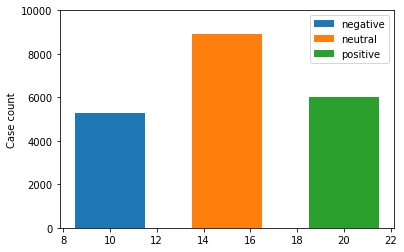

In [89]:
# Now let's visulize three classes
pos_count = data[data['Target'] == 1].shape[0]
neg_count = data[data['Target'] == 2].shape[0]
neu_count = data[data['Target'] == 0].shape[0]

plt.bar(10, neg_count, 3, label='negative')
plt.bar(15, neu_count, 3, label='neutral')
plt.bar(20, pos_count, 3, label='positive')
plt.legend()
plt.ylabel('Case count')
plt.ylim(0, 10000)
plt.show()

_**Data wrangling summary**_:

    Now the dataframe has 20228 cases in total for sentiment analysis, and contains no missing value or typo. 

#### 2.3 Remove stop words, puctuations, and change to lowercase

In [113]:
# This stopword list is copied from https://www.kaggle.com/justk1/roman-urdu-sentiment-analysis
UrduStopWordList = ['nahi', 'nhi', 'nh', 'ney', 'nai', 'nay', 'chi', 'ni', 'na', 'k', 'ye', 'to', 
                    'hai', 'kisi', 'sy', 'hain', 'or', 'tak', 'ek', 'aik', 'kiya', 'liya', 'diya',
                    'dete', 'unhon', 'unhen', 'sey', 'kiye', 'mujhe', 'mjhe', 'bana', 'hue', 
                    'aur', 'wo', 'woh', 'ai', 'aisa', 'waisa', 'mera', 'mere', 'mery', 'meri', 
                    'muzhe', 'mai', 'hum', 'khud', 'acha', 'per', 'har', 'tag', 'bat', 'baat', 
                    'pr', 'he', 'hamara', 'jahan', 'tumhara', 'apka', 'apke', 'wale', 'walon', 
                    'lekin', 'lakin', 'kitna', 'ke', 'hota', 'hon', 'kab', 'kb', 'kabhi', 'sirf', 
                    'hoti', 'hote', 'magar', 'app', 'agar', 'agr', 'pta', 'jab', 'inhe', 'inho', 
                    'in', 'sath', 'esa', 'kaha', 'key', 'kahan', 'jis', 'kia', 'ayi', 'hy', 
                    'main', 'mein', 'me', 'hein', 'hn', 'ki', 'tha', 'ta', 'koi', 'ko', 'woh ', 
                    'bhi', 'yeh', 'raha', 'rha', 'hota', 'ho', 'ga', 'ka', 'leye', 'lye', 'kr', 
                    'kar', 'kry', 'ker', 'lye', 'liye', 'liya', 'hotay', 'waisay', 'gya', 'gaya', 
                    'gae', 'kch', 'kuch', 'ab', 'thy', 'thay', 'houn', 'hain', 'bad', 'baad', 
                    'hai', 'ha', 'sakta', 'han', 'hn', 'hon', 'hoga', 'jin', 'unhen', 'thein',
                    'hoi', 'to', 'toh', 'is', 'isi', 'iss', 'rahe', 'hi', 'h', 'jo', 'a', 'kya',
                    'kyun', 'thi', 'se', 'pe', 'phr', 'phir', 'wala', 'waly', 'wale', 'wali', 
                    'waisay', 'us', 'ny', 'hun', 'hu', 'rha', 'raha', 'ja', 'rahay', 'abi', 
                    'uski', 'use', 'unke', 'unki', 'kon', 'un', 'ne', 'ul', 'haan', 'kafi', 
                    'gai', 'rhy', 'kuch', 'jata', 'ata', 'aye', 'ya', 'dono', 'dy', 'do', 'hoa', 
                    'aese', 'de', 'wohi', 'jati', 'jb', 'krta', 'karta', 'karne', 'karte', 
                    'karti', 'lg', 'lag', 'rahi', 'raha', 'hui', 'hua', 'karna', 'krna', 'gi', 
                    'ge', 'ji', 'hova', 'yehi', 'liya', 'jana', 'di', 'jye', 'chal', 'be', 
                    'mil', 'tu', 'tum', 'aap', 'ap', 'apne', 'apko', 'apki', 'apny', 'apnay', 
                    'apna', 'apni', 'hum', 'hm', 'par', 'hay', 'kis', 'the', 'sb', 'b', 'kr', 
                    'gy', 'tori', 'dain', 'krny', 'tou', 'tu', 'tera', 'teri', 'kay', 'ye', 
                    'iss', 'mien', 'karo', 'kare', 'kro', 'kiya', 'kiye', 'kar', 'ker', 'karta',
                    'ke', 'ik', 'ky', 'e', 'ye', 'firse', 'phirse', 'sub', 'sab', 'usme']


In [114]:
# read the stopword file
text_file = open("./toolbox/stopwords.txt", "r")
stopword = text_file.readlines()
stopword_list = list(set(list(map(lambda s: s.strip(), stopword))+UrduStopWordList))
print(stopword_list)
print(len(stopword_list))
text_file.close()

['waly', 'di', 'per', 'a', 'nhi', 'ni', 'ul', 'rha', 'ne', 'tou', 'woh ', 'ji', 'dono', 'kisi', 'agr', 'hn', 'kuch', 'karne', 'rhy', 'hoa', 'unhon', 'waisa', 'hoti', 'ha', 'krta', 'walon', 'key', 'thein', 'lakin', 'bhi', 'hy', 'hoi', 'aap', 'hote', 'aye', 'or', 'karna', 'apko', 'photo', 'jati', 'tum', 'mujhe', 'dy', 'tera', 'he', 'tu', 'jahan', 'ki', 'de', 'esa', 'krny', 'apni', 'yeh', 'kay', 'jis', 'pta', 'the', 'sub', 'mein', 'gi', 'acha', 'hon', 'karo', 'ho', 'kiye', 'phir', 'jab', 'hova', 'baad', 'rahay', 'kro', 'b', 'k', 'kitna', 'wo', 'chal', 'is', 'lag', 'abi', 'aese', 'dete', 'leye', 'agar', 'tha', 'isi', 'ny', 'bana', 'sy', 'ka', 'dain', 'hain', 'krna', 'kiya', 'jin', 'wale', 'uski', 'liya', 'bat', 'woh', 'kafi', 'hun', 'un', 'ata', 'hota', 'tag', 'tumhara', 'ek', 'sath', 'haan', 'gy', 'hotay', 'mil', 'karti', 'ya', 'bad', 'koi', 'ko', 'yehi', 'sab', 'sakta', 'hi', 'jye', 'diya', 'rahi', 'kia', 'apne', 'aur', 'magar', 'ye', 'hm', 'meri', 'kya', 'kr', 'sent', 'nai', 'inhe', 'hu

In [115]:
# define a function to remove stop words, and make all words to be lowercase
tokenizer = ToktokTokenizer()
def remove_stopwords(text, is_lower_case=False):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens = [token.lower() for token in tokens if token.lower() not in stopword_list]
        
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text

# define a function to remove puctuations
def remove_puctuations(text, is_lower_case=False):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [re.sub(r'[^\w\s]','', token) for token in tokens]
    else:
        filtered_tokens = [re.sub(r'[^\w\s]','', token.lower()) for token in tokens]
        
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text

In [116]:
for i in range (len(data)):
    data.iloc[i, 0] = remove_stopwords(data.iloc[i, 0])
    data.iloc[i, 0] = remove_puctuations(data.iloc[i, 0])

In [117]:
data.head()

,Text,Target
0,sai kha her bus hal kal bi aj aj bi aus say bus,1
1,sahi bt,1
2,bt,1
3,wah je wah,1
4,are wha kaya,1


_**Data wrangling and cleaning summary**_:

Now we have cleaned the text data by dropping the cases with missing values, correcting typoes, removing stop words and puctuations, and change to lowercase. Next step, I will do exploratory data analysis.

#### 3.0 Exploratory Data Analysis(EDA)

##### 3.1 Prepare for EDA

In [145]:
# vectorize all words to be numerical
vect = CountVectorizer(stop_words='english') #, max_df=700) #, min_df=)
corpus_vect = vect.fit_transform(data.Text)
corpus_dtm = pd.DataFrame(corpus_vect.toarray(), columns=vect.get_feature_names())
corpus_dtm.index = data.index

In [146]:
# split the data matrix into three groups for neutral, positive and negative sentiment
neu_dtm = corpus_dtm[data.Target==0]
pos_dtm = corpus_dtm[data.Target==1]
neg_dtm = corpus_dtm[data.Target==2]

#### 3.2 EDA

In [147]:
#!pip install wordcloud
#!pip install textwrap3

In [148]:
from wordcloud import WordCloud
from textwrap import wrap

In [149]:
# define a function to count each token 
def token_count(data):
    token_count = {}
    for token in (vect.get_feature_names()):
        tmp = np.sum(data.loc[:, token])
        token_count[token] = tmp
    return token_count

#pd.DataFrame.from_dict(token_count, orient='index', columns=['count'])

In [150]:
# List the top 10 of frequent tokens for the group with neutral sentiment 
neu_token_count = token_count(neu_dtm)
pd.DataFrame.from_dict(neu_token_count, orient='index', columns=['count']).sort_values('count', ascending=False).head(10)

,count
khan,272
pakistan,229
bhai,164
allah,157
say,140
film,140
hahaha,124
saal,114
lahore,113
sir,111


In [151]:
# List the top 10 of frequent tokens for the group with positive sentiment 
pos_token_count = token_count(pos_dtm)
pd.DataFrame.from_dict(pos_token_count, orient='index', columns=['count']).sort_values('count', ascending=False).head(10)

,count
allah,759
pakistan,293
khan,292
bohat,280
ameen,265
dua,216
pak,213
achi,204
bht,173
good,165


In [152]:
# List the top 10 of frequent tokens for the group with negative sentiment 
neg_token_count = token_count(neg_dtm)
pd.DataFrame.from_dict(neg_token_count, orient='index', columns=['count']).sort_values('count', ascending=False).head(10)

,count
allah,178
pakistan,166
khan,162
say,154
log,130
lanat,130
kam,118
bhai,112
nawaz,104
gaye,93


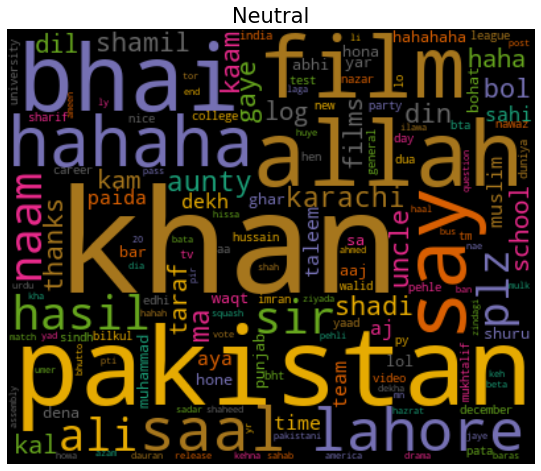

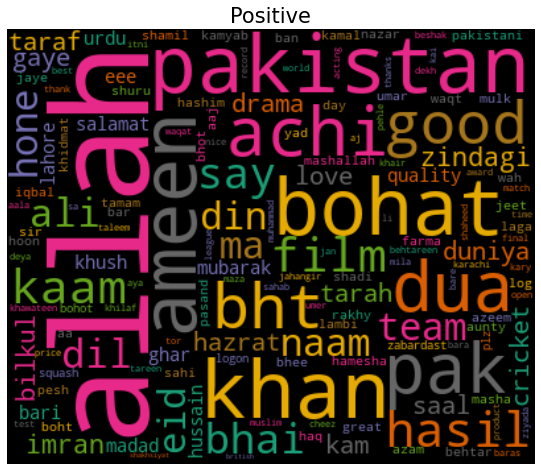

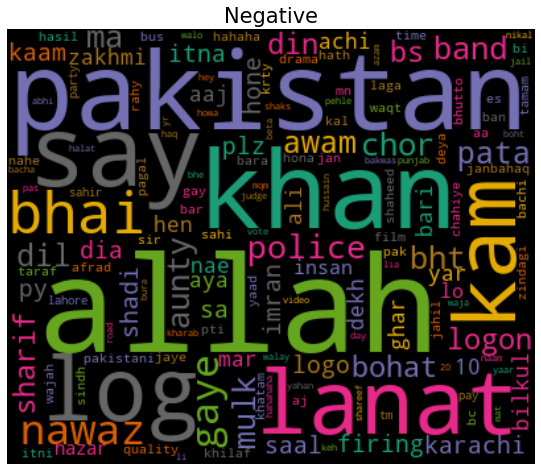

In [161]:
# Function for generating word clouds
def generate_wordcloud(data, label=None):
    wc = WordCloud(width=400, height=330, max_words=150,colormap="Dark2").generate_from_frequencies(data)
    plt.figure(figsize=(10,8))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.title('\n'.join(wrap(label,60)),fontsize=21)
    plt.show()

# Plotting word cloud for each sentiment group
generate_wordcloud(neu_token_count, label='Neutral')
generate_wordcloud(pos_token_count, label='Positive')
generate_wordcloud(neg_token_count, label='Negative')

### Summary:
